# Twitter sentiment analysis

## Imports and load data

In [23]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

# general imports
import numpy as np
import pandas as pd
import subprocess
from textblob import TextBlob
import re
import time
import datetime

# plotting and visualization
import matplotlib
import matplotlib.dates as mdates #from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter, YearLocator
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def runCmd(cmd, run=False):
    '''
    use stdout to run command and shell=True to allow command to be entered as a string
    use rstrip() to remove carriage return and decode binary form to string. 
     '''
    if run == False:
        try:
            output_cmd = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
            output_cmd = output_cmd.rstrip().decode('UTF-8')
        except subprocess.CalledProccessError as e:
            print("Command", e.cmd, "returned with error code", e.returncode)
            print("setting output_cmd to empty array")
            output_cmd = []
        return output_cmd
    else:
        subprocess.Popen(cmd, stderr=subprocess.STDOUT, shell=True)
        return None

def S2_from_csv(filename):
    return pd.read_csv(filename, parse_dates=['date'], encoding='latin')

### file name

In [3]:
current_dir = ['complete_tweets/' + x for x in runCmd('ls complete_tweets/').split('\n') if '.csv' in x]
print("Data files available to load. Please select merged complete_tweet files")
for i, x in enumerate(current_dir):
    print(str(i), " ", x)
    
value_selection = input("\nPlease input file numbers separated by a space ")
#value_selection = [ int(x) for x in value_selection.split() ]
value_selection = int(value_selection)
S2 = S2_from_csv(current_dir[value_selection])

Data files available to load. Please select merged complete_tweet files
0   complete_tweets/complete_tweets_2018_01.csv
1   complete_tweets/complete_tweets_2018_02.csv
2   complete_tweets/complete_tweets_2018_03.csv
3   complete_tweets/complete_tweets_2018_04.csv
4   complete_tweets/complete_tweets_2018_05.csv
5   complete_tweets/complete_tweets_2018_06.csv
6   complete_tweets/complete_tweets_2018_07.csv
7   complete_tweets/complete_tweets_2018_08.csv
8   complete_tweets/complete_tweets_2018_09.csv
9   complete_tweets/complete_tweets_2018_10-12.csv
10   complete_tweets/complete_tweets_2018_10.csv
11   complete_tweets/complete_tweets_2018_11.csv
12   complete_tweets/complete_tweets_2018_12.csv
13   complete_tweets/complete_tweets_2018_trim.csv
14   complete_tweets/complete_tweets_2018_uncut.csv
15   complete_tweets/complete_tweets_tweets_2018-09-01_2018-09-15.csv
16   complete_tweets/tweets_2017-11-16_2017-12-31.csv
17   complete_tweets/tweets_2018-01-01_2018-01-14.csv
18   complete_twe

In [4]:
S2.shape

(36500, 11)

## Sentiment analysis

In [5]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet, method='to_int'):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    
    # convert to integer
    if method == 'to_int':
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    elif method == 'to_float':
        return analysis.sentiment.polarity
    else:
        print('unrecognized sentiment method')
    

def sentiment_analysis(S2_sentiment):
    # We create a column with the result of the analysis:
    S2_sentiment['SA'] = np.array([ analize_sentiment(tweet, method='to_float') for tweet in S2_sentiment['tweets'] ])
    S2_sentiment['SA_int'] = np.array([ analize_sentiment(tweet, method='to_int') for tweet in S2_sentiment['tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2_sentiment['tweets']) if S2_sentiment['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2_sentiment['tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2_sentiment['tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2_sentiment['tweets'])))

In [6]:
sentiment_analysis(S2)

Percentage of positive tweets: 33.81643835616438%
Percentage of neutral tweets: 55.47671232876712%
Percentage de negative tweets: 10.706849315068494%


In [7]:
S2['rounded_hour'] = S2['date'].dt.round('H')
S2['rounded_day'] = pd.to_datetime(S2['rounded_hour'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
S2['rounded_week'] = pd.to_datetime(S2['rounded_hour'], format='%Y-%m-%d').dt.strftime('%Y-%W')
S2['rounded_month'] = pd.to_datetime(S2['rounded_hour'], format='%Y-%m-%d').dt.strftime('%Y-%m')

In [8]:
S2.tail()

,date,tweets,user_name,user_screen_name,user_followers,user_friends,user_verified,user_language,retweet_count,favorite_count,rounded_hour,SA,SA_int,rounded_day,rounded_week,rounded_month
36495,2018-12-30 23:58:06,@Dee_Wetzel @ProfFaustus Bitcoin can only be a...,Bitcoin Sofia,BitcoinSofia,191.0,114.0,False,en,0.0,2.0,2018-12-31,-0.125000,-1,2018-12-31,2018-53,2018-12
36496,2018-12-30 23:58:04,"Top Cryptocurrencies Mostly in the Red, Bitcoi...",Rebel Capital,rebelcapitalio,15.0,3.0,False,en,0.0,0.0,2018-12-31,0.333333,1,2018-12-31,2018-53,2018-12
36497,2018-12-30 23:58:04,RT @patrickrooney: Wells Fargo Says Bitcoin To...,Sants $XRP RNTL,YNGM_sants,2272.0,958.0,False,en,0.0,0.0,2018-12-31,0.416667,1,2018-12-31,2018-53,2018-12
36498,2018-12-30 23:58:01,Bounties and Responsible Disclosure Bolstered ...,Bitcoin Investment Lending,BitcoinInvest24,243.0,174.0,False,en,0.0,0.0,2018-12-31,0.200000,1,2018-12-31,2018-53,2018-12
36499,2018-12-30 23:58:01,"RT @TonyRobbins: What the heck is bitcoin, and...",cryptojoker,cryptojokerrr,78.0,104.0,False,en,0.0,0.0,2018-12-31,0.000000,0,2018-12-31,2018-53,2018-12


## Stacked bar chart

In [43]:
#S2['rounded_day'] = S2['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
#S2['rounded_hour'] = S2['date'].dt.round('H')

S3_A = S2.groupby(['rounded_hour']).agg('count').reset_index()
S3 = S2.groupby(['rounded_hour', 'SA_int']).agg('count').reset_index()
S3 = S3.assign(count = S3['tweets']).loc[:,['rounded_hour', 'SA_int', 'count']]
S3_pivot = S3.pivot(index = 'rounded_hour', columns='SA_int', values='count')

S3_pivot.head()

SA_int,-1,0,1
rounded_hour,,,
2018-01-01,12,50,38
2018-01-02,10,50,40
2018-01-03,13,47,40
2018-01-04,12,43,45
2018-01-05,19,49,32


In [84]:
'''cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
'''

def plot_stacked_bar(df, x, y, nrows=1, ncols=1):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    #fig, ax = plt.subplots()
    
    #ax.plot(df[x], df[y], '.')
    df.plot.bar(stacked=True, ax=ax, colormap='Spectral')

    plt.style.use('ggplot')
    ax.legend(loc=0)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    #fig.savefig('stacked_bar_chart_SA.png')
    #plt.close()
    plt.show()

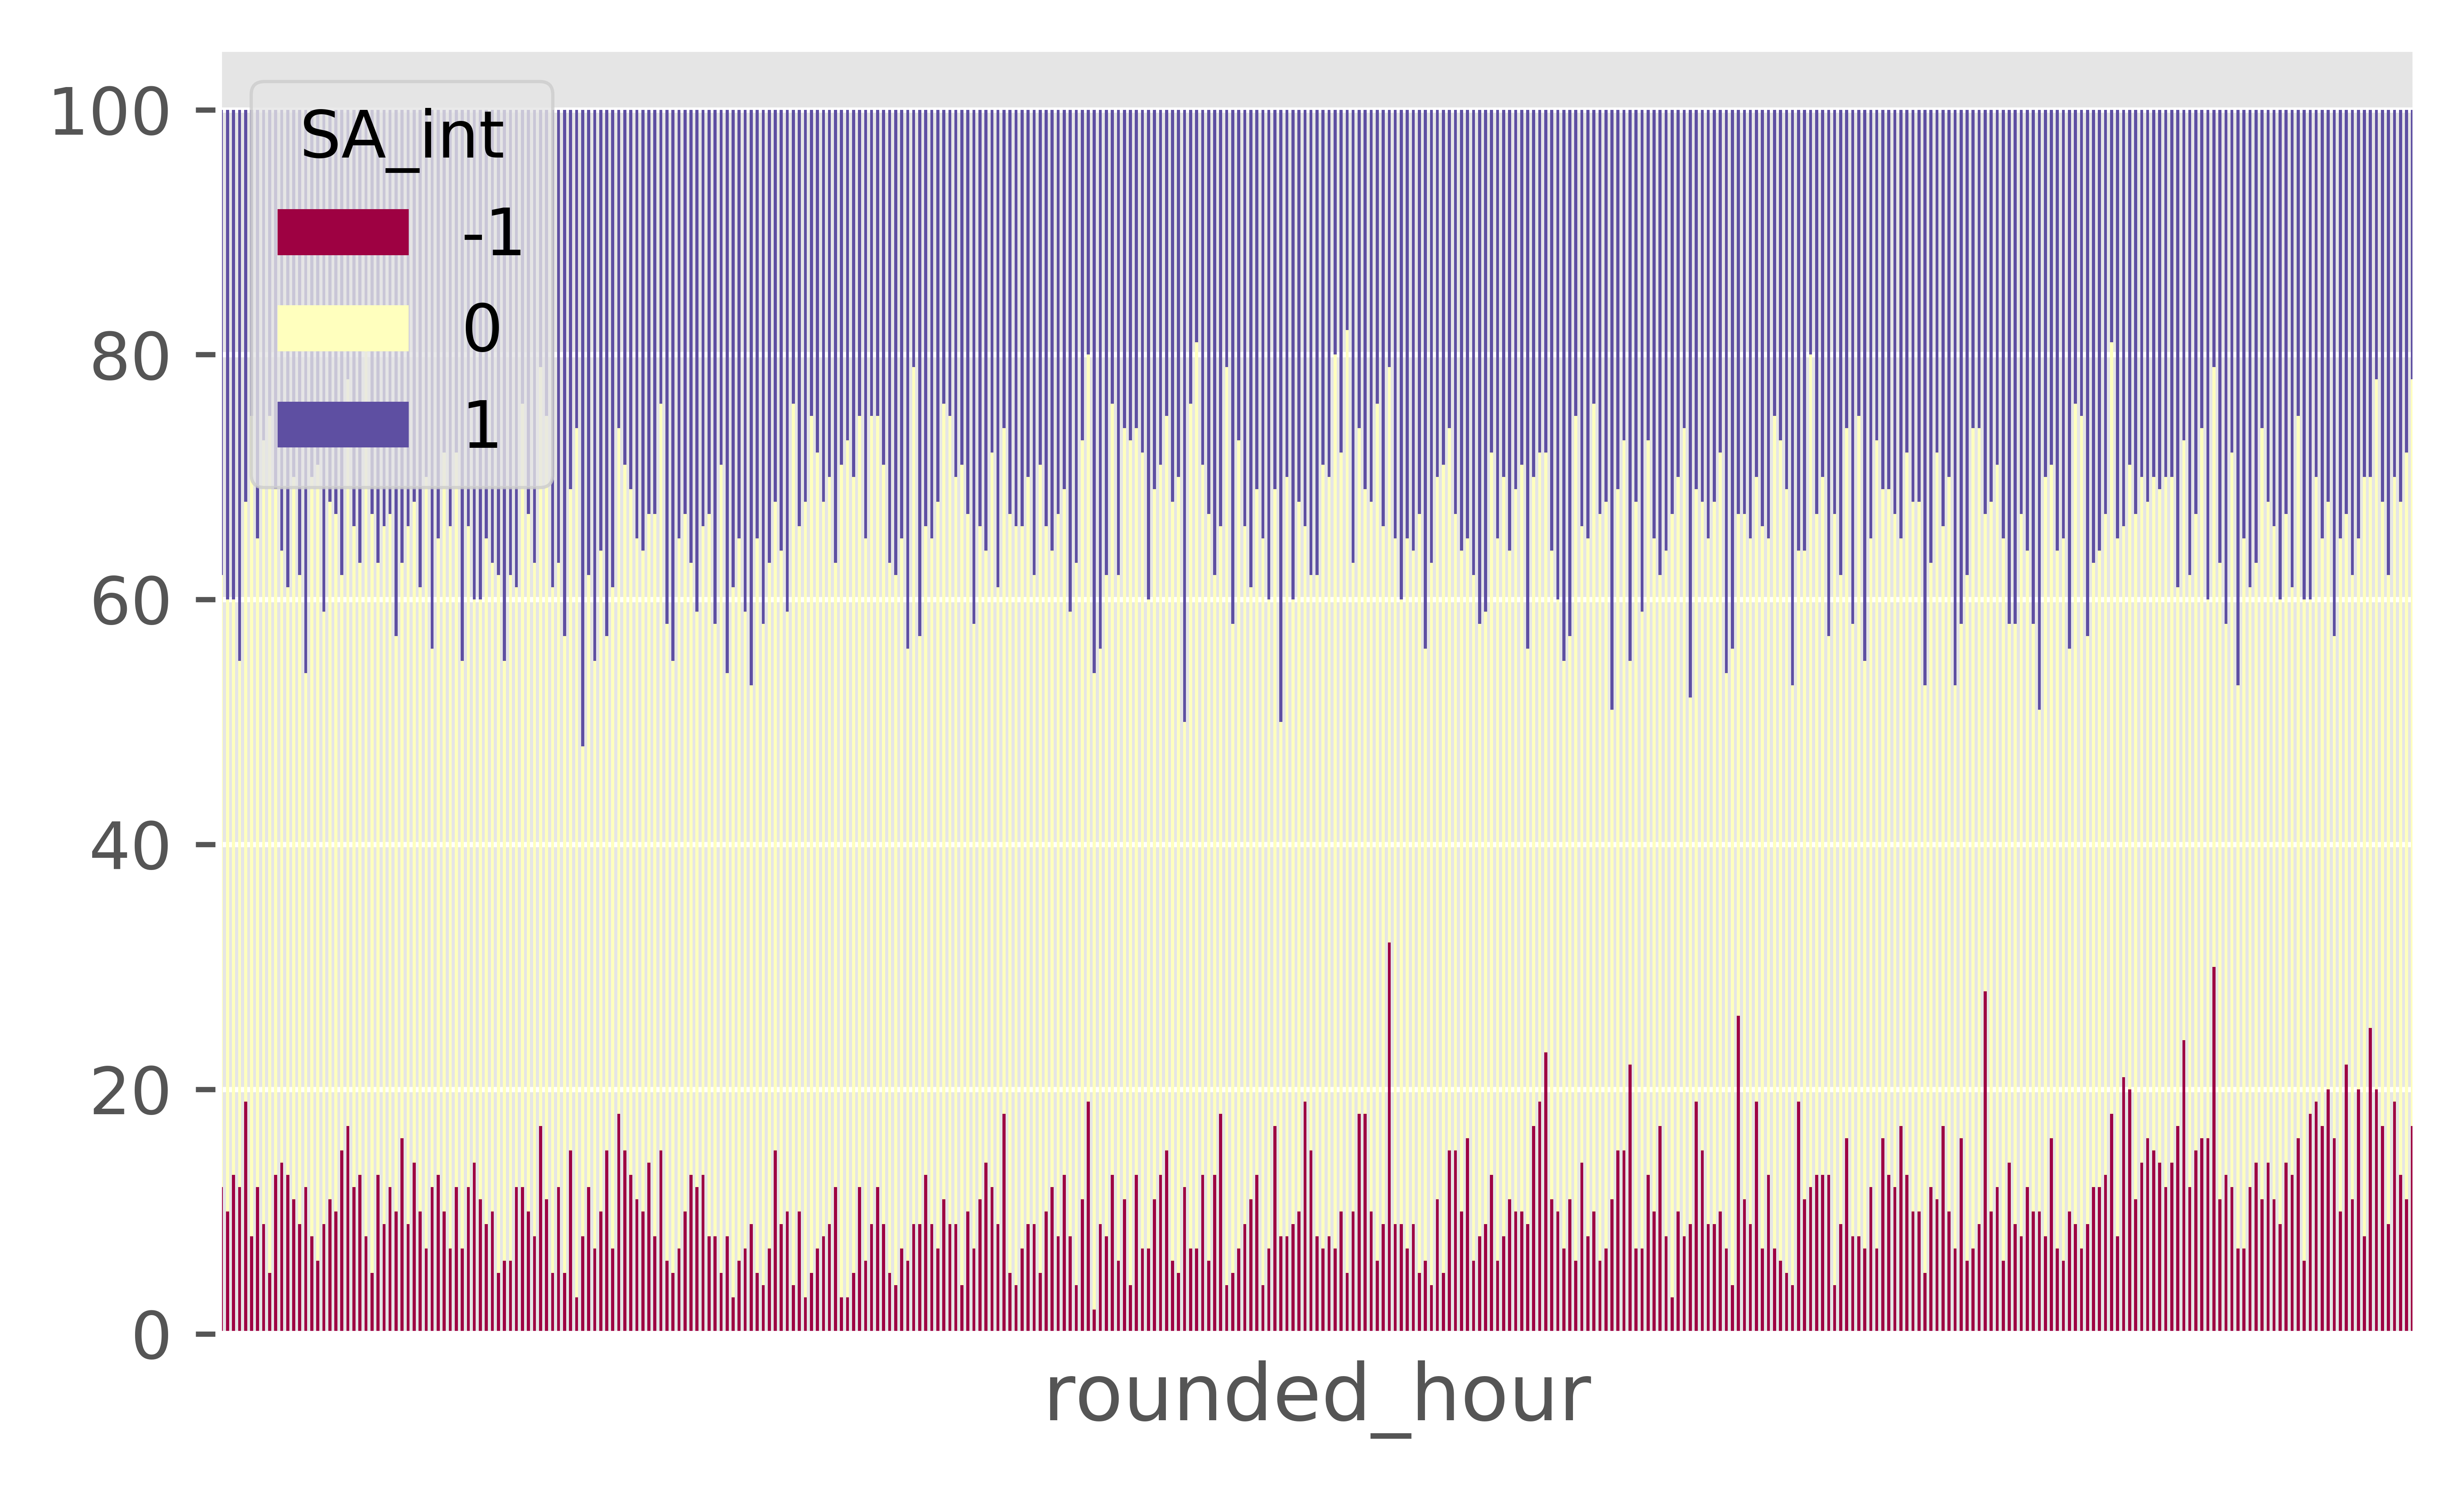

In [85]:
plot_stacked_bar(S3_pivot, 'rounded_week', 'SA')

### Line graph

In [40]:
S2['rounded_week'].unique()

array(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2018-13', '2018-14', '2018-15', '2018-16', '2018-17', '2018-18',
       '2018-19', '2018-20', '2018-21', '2018-22', '2018-23', '2018-24',
       '2018-25', '2018-26', '2018-27', '2018-28', '2018-29', '2018-30',
       '2018-31', '2018-32', '2018-33', '2018-34', '2018-35', '2018-36',
       '2018-37', '2018-38', '2018-39', '2018-40', '2018-41', '2018-42',
       '2018-43', '2018-44', '2018-45', '2018-46', '2018-47', '2018-48',
       '2018-49', '2018-50', '2018-51', '2018-52', '2018-53'],
      dtype=object)

In [54]:
S2['date'][::30*100]

0       2017-12-31 23:59:59
3000    2018-01-30 23:59:59
6000    2018-03-01 23:59:59
9000    2018-03-31 23:59:58
12000   2018-04-30 23:59:59
15000   2018-05-30 23:59:58
18000   2018-06-29 23:59:59
21000   2018-07-29 23:57:07
24000   2018-08-28 23:56:31
27000   2018-09-27 23:59:57
30000   2018-10-27 23:59:58
33000   2018-11-26 23:59:58
36000   2018-12-26 23:59:58
Name: date, dtype: datetime64[ns]

In [46]:
def line_graph(df, x, y1, y2, nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    ax2 = ax.twinx()
    
    # aggregate by x axis and join with original data
    y1_label = x + '_' + y1
    y2_label = x + '_' + y2
    df_temp = df[[x, y1, y2]]
    df_temp = df_temp.groupby([x]).agg('mean')
    df_temp = df_temp.rename(columns = { y1: y1_label, y2: y2_label } )
    df_join = pd.merge(df, df_temp, how='left', on=[x])
    plot_y1 = ax.plot(df_join['date'], df_join[y1_label], label = y1_label, color='green')
    plot_y2 = ax2.plot(df_join['date'], df_join[y2_label], label= y2_label, color='blue')
    
    # format x axis
    months = mdates.MonthLocator() # MonthLocator without args set ticks for every month
    monthsFmt = mdates.DateFormatter("%b")
    years = mdates.YearLocator(month=1, day=1)
    yrsFmt = mdates.DateFormatter("\n%Y") # correct year descriptor
    
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)
    for tick in ax.xaxis.get_minor_ticks():tick.label.set_fontsize(9) 
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yrsFmt)
    plt.gcf().autofmt_xdate()
    
    # set graph labels
    ax.set_xlabel(x)
    ax.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    #ax2.set_ylim(0, 35)
    #ax.set_ylim(-20,100)
    plot_y = plot_y1 + plot_y2
    labs = [l.get_label() for l in plot_y]
    ax.legend(plot_y, labs, loc=0)
    
    plt.show()

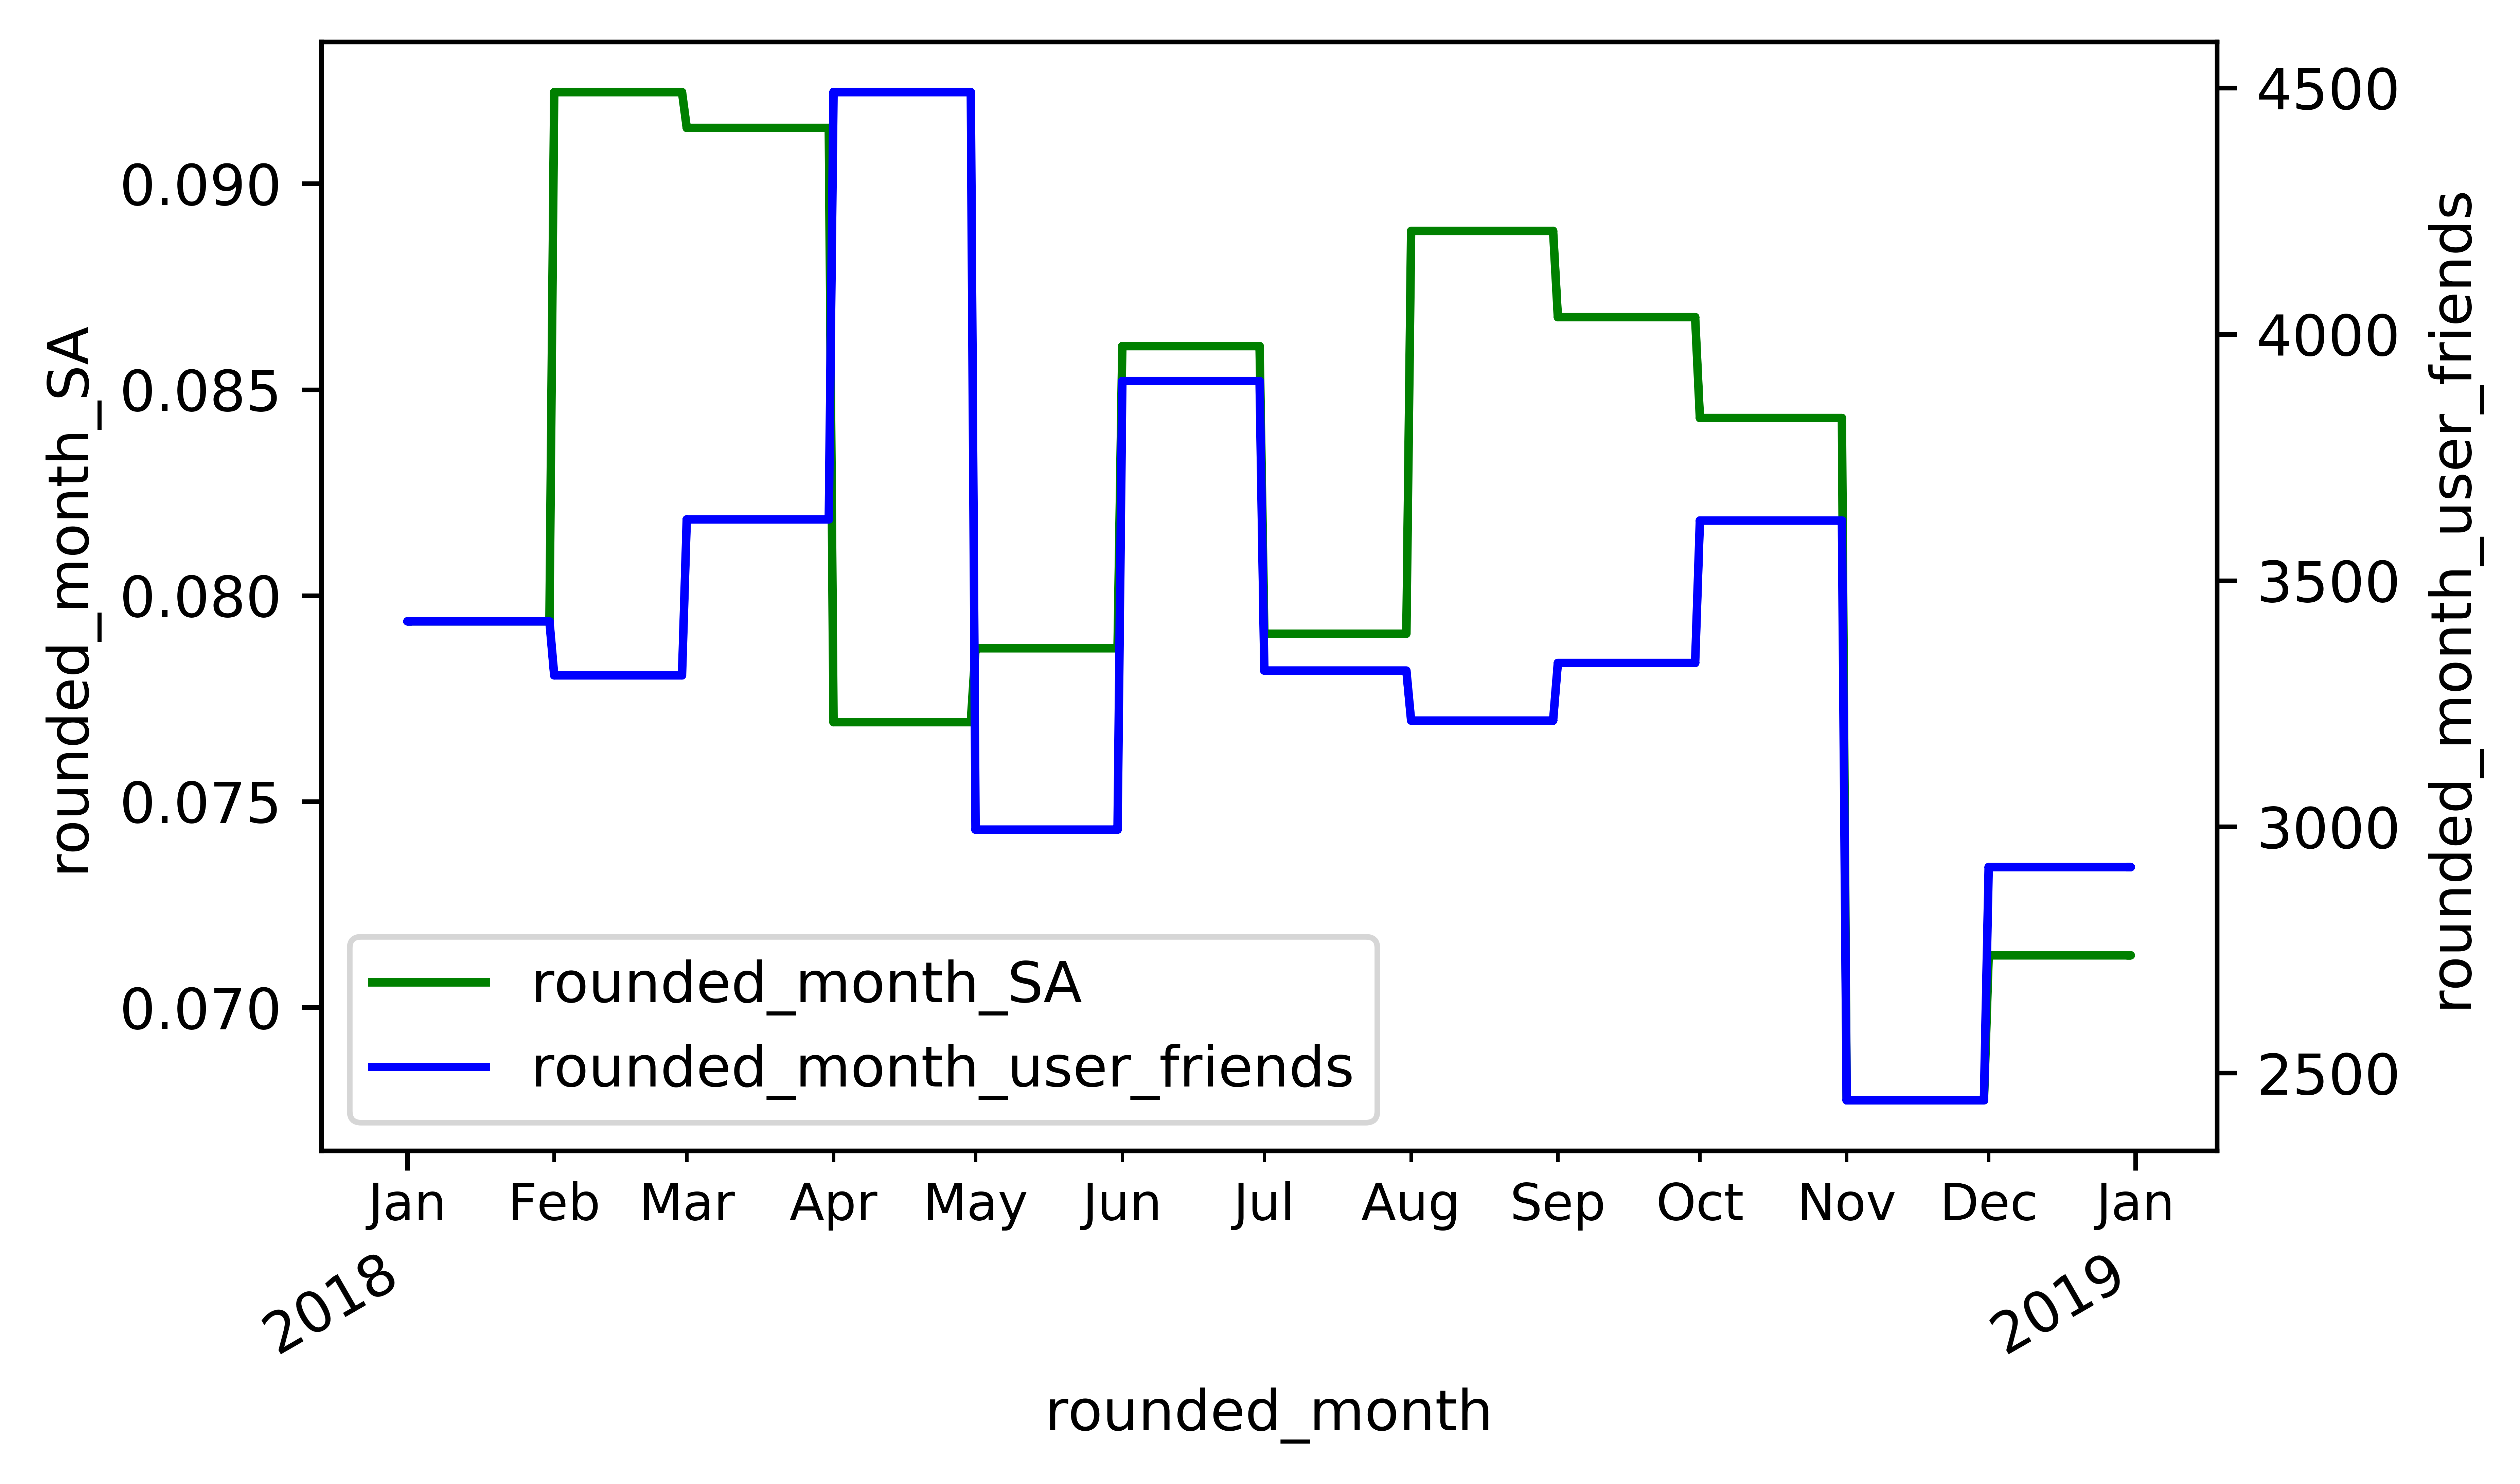

In [48]:
line_graph(S2, 'rounded_month', 'SA', 'user_friends')